# Final Project: Food Recipes and Reviews

This project will focus on a large dataset derived from web scraping Food.com. The dataset comprises a substantial number of recipes, each accompanied by ingredient lists, cooking instructions, preparation and cooking times, and descriptive summaries. In addition, it includes user reviews, featuring both numerical ratings and written evaluations of the recipes.

The objectives of the project are twofold. First, I will conduct a network analysis to investigate the interactions between ingredients across recipes, aiming to identify which ingredients serve as central nodes within the network. It is hypothesized that fundamental ingredients such as sugar, salt, and flour will exhibit high centrality measures. Second, I will perform a textual analysis of recipe descriptions to assess whether the language used correlates with positive user reviews. Specifically, the analysis will examine whether the presence and frequency of particular keywords in descriptions are associated with higher user engagement and ratings. These findings could inform strategic business decisions, such as optimizing recipe descriptions to enhance user interaction and satisfaction on the platform.

[Kaggle](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_interactions.csv)

[Explanation](https://youtu.be/9JxIIqNYIgY)

## Required Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import networkx as nx
from itertools import combinations
from networkx.algorithms import bipartite
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Import Datasets

We will import the recipes and user review datasets

In [3]:
recipes_df = pd.read_csv('RAW_recipes.csv')
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


Recipe ingredients is a long string and not a list. We will need to change it to become a list instead. 

In [4]:
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else [])

In [5]:
users_df = pd.read_csv('RAW_interactions.csv')
users_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


## Ignore Duplicates

We want to ensure we do not have any recipes or user reviews on the same recipe. 

In [6]:
recipes_df = recipes_df.drop_duplicates(subset=['id'])
users_df = users_df.drop_duplicates(subset=['user_id', 'recipe_id'])

## Long List Format of Ingredients

We want to change how the data is stored in lists and into a long format that can associate a single ingredient to the recipe. 

In [7]:
recipes_exploded = recipes_df[['name', 'id', 'ingredients']].explode('ingredients')
recipes_exploded.head()

,name,id,ingredients
0,arriba baked winter squash mexican style,137739,winter squash
0,arriba baked winter squash mexican style,137739,mexican seasoning
0,arriba baked winter squash mexican style,137739,mixed spice
0,arriba baked winter squash mexican style,137739,honey
0,arriba baked winter squash mexican style,137739,butter


## Merge Datasets

We will merge each recipe to its corresponding user reviews

In [8]:
recipes_network = pd.merge(recipes_exploded, users_df, left_on='id', right_on='recipe_id', how='left')
recipes_network.head()

,name,id,ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,winter squash,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,winter squash,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,winter squash,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,arriba baked winter squash mexican style,137739,mexican seasoning,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
4,arriba baked winter squash mexican style,137739,mexican seasoning,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...


## Exploratory Data Analysis

### Total Unique Instances

We have a total of about 230K recipes, 15K unique ingredients and roughly 226K unique users who provided a review. 

In [9]:
recipes_network['id'].nunique()

231637

In [10]:
recipes_network['ingredients'].nunique()

14942

In [11]:
recipes_network['user_id'].nunique()

226570

### Number of Times Ingredient Was Used

We can see we have salt leading the list of ingredients by about 25% more than the next one being butter. Sugar comes in third at almost 50% less than salt. 

In [12]:
recipes_network.groupby(['ingredients'])['recipe_id'].nunique().reset_index().sort_values(by='recipe_id', ascending=False).rename(columns={'recipe_id':'total_recipes'}).head(10)

,ingredients,total_recipes
11751,salt,85746
1651,butter,54975
12908,sugar,44535
9414,onion,39065
14316,water,34914
4453,eggs,33761
9397,olive oil,32822
4941,flour,26266
8727,milk,25786
5692,garlic cloves,25748


## Network Centrality Measures

Lets set up our dataset to evaluate some centrality measures. We will group by *recipe_id* to get lists of ingredients per recipe. 


In [13]:
grouped = recipes_network.groupby('recipe_id')['ingredients'].apply(set).reset_index().sample(1000, random_state=123)


Developing an undirected graph where edges pair each pair of ingredients in the same recipe to itself. 

In [14]:
G = nx.Graph()

for ingredients in grouped['ingredients']:
    for ingredient1, ingredient2 in combinations(ingredients, 2):
        if G.has_edge(ingredient1, ingredient2):
            G[ingredient1][ingredient2]['weight'] += 1
        else:
            G.add_edge(ingredient1, ingredient2, weight=1)

### Degree Centrality

Determining degree centraility shows us that salt leads the most important node in our network, but surprsingly onion comes in second ahead of butter. Sugar falls down the list to 6th place in the rankings. 

In [15]:
degree_centrality = nx.degree_centrality(G)

degree_df = pd.DataFrame(degree_centrality.items(), columns=['ingredient', 'degree_centrality'])
degree_df = degree_df.sort_values(by='degree_centrality', ascending=False)
degree_df.head(10)

,ingredient,degree_centrality
4,salt,0.525510
14,onion,0.350510
44,butter,0.331633
18,water,0.321939
83,olive oil,0.306633
24,sugar,0.301531
29,garlic cloves,0.275510
6,eggs,0.253571
37,pepper,0.220918
27,garlic,0.207143


### Eigenvector Centrality

Eigenvector centrality has our rankings similar to our degree centality, however, sugar falls another rank lower to 7th place on our list. 

In [16]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

eigen_df = pd.DataFrame(eigenvector_centrality.items(), columns=['ingredient', 'eigenvector_centrality'])
eigen_df = eigen_df.sort_values(by='eigenvector_centrality', ascending=False)

eigen_df.head(10)

,ingredient,eigenvector_centrality
4,salt,0.199733
14,onion,0.161850
44,butter,0.151052
18,water,0.150989
83,olive oil,0.149960
29,garlic cloves,0.139321
24,sugar,0.137810
6,eggs,0.125146
37,pepper,0.124234
27,garlic,0.117444


## Plotting our Centrality Measures Network

To keep our network graph simple we will plot the top 25 nodes (ingredients) in our network and then highlight the top 5 on the list overall. When we look at both our networks we can clearly see how our top 5 ingredients cluster near each other and also is central in its placement on the structure of the network. What we learn here is that most of our recipes are quite reliant on these ingredients and become a foundational need in most recipes. 

In [17]:
G_subgraph = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Use raw centrality values directly
degree_centrality_values = degree_centrality
eigenvector_centrality_values = eigenvector_centrality

# Get top 25 nodes by degree centrality
nodes_top25_degree = sorted(degree_centrality_values, key=degree_centrality_values.get, reverse=True)[:25]
nodes_top5_degree = nodes_top25_degree[:5]

# Get top 25 nodes by eigenvector centrality
nodes_top25_eigen = sorted(eigenvector_centrality_values, key=eigenvector_centrality_values.get, reverse=True)[:25]
nodes_top5_eigen = nodes_top25_eigen[:5]

# Create subgraphs for top 25 ingredients
G_degree_25 = G_subgraph.subgraph(nodes_top25_degree).copy()
G_eigen_25 = G_subgraph.subgraph(nodes_top25_eigen).copy()

# Layouts
pos_degree_25 = nx.spring_layout(G_degree_25, seed=123, k=0.1)
pos_eigen_25 = nx.spring_layout(G_eigen_25, seed=123, k=0.1)

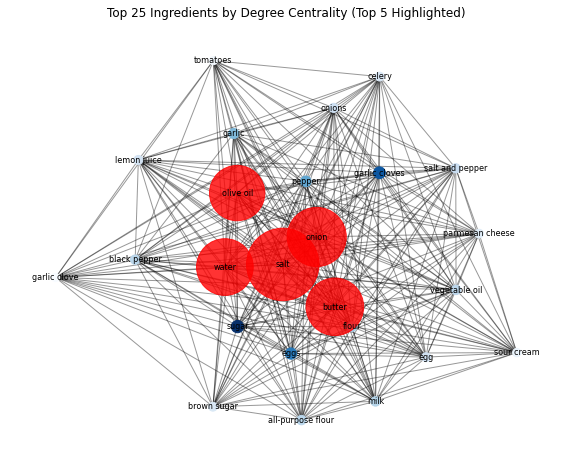

In [18]:
# Plot Degree Centrality
plt.figure(figsize=(10, 8))
non_top5_nodes_degree = [n for n in G_degree_25.nodes() if n not in nodes_top5_degree]
nx.draw_networkx_nodes(G_degree_25, pos_degree_25,
                       nodelist=non_top5_nodes_degree,
                       node_size=[degree_centrality_values[n]*500 for n in non_top5_nodes_degree],
                       node_color=[degree_centrality_values[n] for n in non_top5_nodes_degree],
                       cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G_degree_25, pos_degree_25,
                       nodelist=nodes_top5_degree,
                       node_size=[degree_centrality_values[n]*10000 for n in nodes_top5_degree],
                       node_color='red', alpha=0.8)
nx.draw_networkx_edges(G_degree_25, pos_degree_25, alpha=0.4)
nx.draw_networkx_labels(G_degree_25, pos_degree_25, font_size=8)
plt.title("Top 25 Ingredients by Degree Centrality (Top 5 Highlighted)")
plt.axis('off')
plt.show()

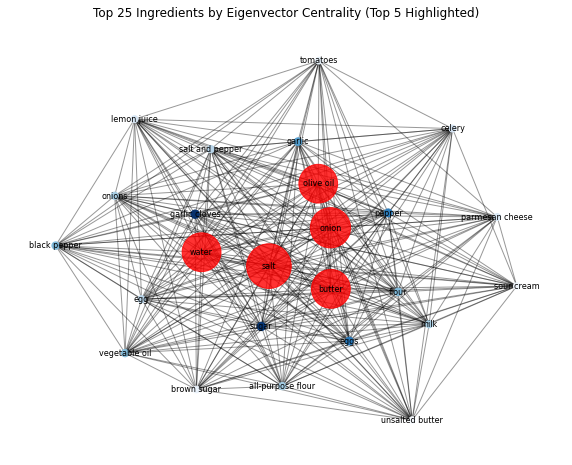

In [19]:
# Plot Eigenvector Centrality
plt.figure(figsize=(10, 8))
non_top5_nodes_eigen = [n for n in G_eigen_25.nodes() if n not in nodes_top5_eigen]
nx.draw_networkx_nodes(G_eigen_25, pos_eigen_25,
                       nodelist=non_top5_nodes_eigen,
                       node_size=[eigenvector_centrality_values[n]*500 for n in non_top5_nodes_eigen],
                       node_color=[eigenvector_centrality_values[n] for n in non_top5_nodes_eigen],
                       cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G_eigen_25, pos_eigen_25,
                       nodelist=nodes_top5_eigen,
                       node_size=[eigenvector_centrality_values[n]*10000 for n in nodes_top5_eigen],
                       node_color='red', alpha=0.8)
nx.draw_networkx_edges(G_eigen_25, pos_eigen_25, alpha=0.4)
nx.draw_networkx_labels(G_eigen_25, pos_eigen_25, font_size=8)
plt.title("Top 25 Ingredients by Eigenvector Centrality (Top 5 Highlighted)")
plt.axis('off')
plt.show()

## Unweighted and Weighted Network

Continuing to discover what our network does, we will create an unweighted and weighted bipartite graph. What this will do for us is that we want to see the relationship of ingredients to how many people in our network it will reach out to and generate reviews. To keep our analysis simple and avoid computational problems, we will only use recipes that contain any of our top 25 ingredients. As long it contains one of these ingredients we will keep it as a recipe to evaluate. 

In [20]:
top_25_degree = degree_df.reset_index(drop=True)['ingredient'][:25]
top_25_eigen = eigen_df.reset_index(drop=True)['ingredient'][:25]

In [21]:
top_25_combined = pd.concat([top_25_degree, top_25_eigen]).unique()
len(top_25_combined)

26

In [22]:
bipartite_data = recipes_network[['ingredients', 'recipe_id']]
bipartite_data_filtered = bipartite_data[bipartite_data['ingredients'].isin(top_25_combined)]
bipartite_data_filtered.head()

,ingredients,recipe_id
12,butter,137739
13,butter,137739
14,butter,137739
15,olive oil,137739
16,olive oil,137739


Next, we will focus on a random sample of 1K recipes to build our unweighted and weighted networks.

In [23]:
unique_recipe_ids = bipartite_data_filtered['recipe_id'].unique()
unique_recipe_series = pd.Series(unique_recipe_ids)
sample_recipe_ids = unique_recipe_series.sample(n=1000, random_state=123)

bipartite_data_sample = recipes_network[recipes_network['recipe_id'].isin(sample_recipe_ids)]

In [24]:
len(bipartite_data_sample['ingredients'].unique())

1844

### Unweighted Network

In [25]:
R = nx.Graph()

R.add_nodes_from(bipartite_data_sample["ingredients"], bipartite=0)  
R.add_nodes_from(bipartite_data_sample["recipe_id"], bipartite=1)   
R.add_edges_from(zip(bipartite_data_sample["ingredients"], bipartite_data_sample["recipe_id"]))  

recipe_nodes = bipartite_data_sample["recipe_id"].unique()
projected_graph = nx.bipartite.projected_graph(R, recipe_nodes)

recipe_degree_df = pd.DataFrame(list(projected_graph.degree()), columns=['Recipe', 'Users']).sort_values(by='Users', ascending=False)
recipe_degree_df.head(10)

,Recipe,Users
592,425234,849
46,69861,832
421,148359,825
430,401815,812
189,233436,788
8,313066,783
982,378407,779
206,117056,778
253,108693,778
57,41948,778


### Weighted Network

In [26]:
weighted_projected_graph = bipartite.weighted_projected_graph(R, recipe_nodes)
recipe_weight_df = pd.DataFrame(list(weighted_projected_graph.degree(weight='weight')), columns=['Recipe', 'Users']).sort_values(by='Users', ascending=False)
recipe_weight_df.head(10)

,Recipe,Users
592,425234,1748
46,69861,1691
430,401815,1618
253,108693,1532
421,148359,1527
711,146034,1522
710,267189,1496
8,313066,1489
936,223857,1483
189,233436,1475


The results show us that the top two recipes 425234 and 69861 reaches most the diverse users in our network. What we can then determine is that if we wanted to introduce recipes to new users, these recipes can create the most interactions on our website. This does not mean that it could create the most positive experience but that it can create the most lively discussion to warrant leaving feedback

## Recipe Descriptions, NLTK and Positive Feedback

Continuing our evaluation, we can see if a well written description of recipes will lead to general positive feedback. Are there certain words that lead to good experiences?

### Develop Word Frequency Table

We will take a sample of 10K recipes and develop a word frequency table to determine how often it appears in the recipe description and relative to our corpus of recipes. We will also remove stopwords such as 'a' and 'the' as it does not provide any useful information. 

In [27]:
## Remove stopwords
stop_words = set(stopwords.words('english'))

## Sample 10K recipe descriptions
recipe_description = recipes_df[['id', 'description']].sample(10000, random_state=123)

recipe_description = recipe_description.rename(columns={'id': 'recipe_id'})

In [28]:
def normalized_word_freq(text):
    if not isinstance(text, str):
        return {}
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stop_words]
    total = len(filtered_words)
    counts = Counter(filtered_words)
    return {word: count / total for word, count in counts.items()} if total > 0 else {}

In [29]:
recipe_description['word_freq'] = recipe_description['description'].apply(normalized_word_freq)
recipe_description_reset = recipe_description.reset_index(drop=True)

## Create DataFrame
word_freq_df = pd.DataFrame(recipe_description_reset['word_freq'].to_list()).fillna(0)

## Combine with recipe ID
result_df = pd.concat([recipe_description_reset[['recipe_id']], word_freq_df], axis=1)
result_df.head()

,recipe_id,favorite,mine,great,low,carb,easy,make,cheesy,cauliflower,...,appleton,pewaukee,derives,beggar,purses,beauties,sparkled,mugs,hesitated,agua
0,318526,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,161266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,233665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,306936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Standardize User Reviews

Here we will merge our datasets again where we will determine if the user review is good or bad. We will then aggregate these reviews for an overall sentiment of the recipe. The idea will be that a review that recieves a 0 to 2 will be bad while when receiving a 3 to 5 is good. If the overall counts of the recipes leads to an overall more "good" sentiment, then it will be categorized as a recipe with an *overall_sentiment* of positive. This will become our dependent variable to use with our feature variables of word frequencies. 

In [30]:
## Merge the two DataFrames on recipe_id (id in result_df)
merged_df = result_df.merge(users_df, left_on='recipe_id', right_on='recipe_id')

## If the column is named 'rating_y', rename it to 'rating'
merged_df.rename(columns={'rating_y': 'rating'}, inplace=True)

In [78]:
## Classify ratings: 0-2 = 'bad', 3-5 = 'good'
merged_df['review_quality'] = merged_df['rating'].apply(lambda x: 'good_rating' if x >= 4 else 'bad_rating')

## Count good and bad reviews per recipe
sentiment_counts = merged_df.groupby('recipe_id')['review_quality'].value_counts().unstack(fill_value=0)

## Compute average rating per recipe
average_ratings = merged_df.groupby('recipe_id')['rating'].mean().rename('average_rating')

In [81]:
## Combine into one summary DataFrame
summary_df = sentiment_counts.join(average_ratings)

## Determine overall sentiment
summary_df['overall_sentiment'] = summary_df.apply(
    lambda row: 'positive' if row.get('good_rating', 0) > row.get('bad_rating', 0) else 'negative',
    axis=1
)

summary_df = summary_df.reset_index()
summary_df.head(10)

,recipe_id,bad_rating,good_rating,average_rating,overall_sentiment
0,100,2,0,3.00,negative
1,114,0,4,5.00,positive
2,118,1,1,4.00,negative
3,128,0,2,5.00,positive
4,133,0,4,4.75,positive
5,252,1,1,4.00,negative
6,273,0,2,5.00,positive
7,365,0,1,5.00,positive
8,418,0,1,5.00,positive
9,460,3,3,2.50,negative


### Overall Sentiment Encoding

We have to make sure that we provide a binary, numeric value for our feature value as our models require this as opposed to using string text. 

In [82]:
merged_final_df = result_df.merge(summary_df, on='recipe_id', how='left')

## Encode 'overall_sentiment' as numeric (1 for good, 0 for bad)
merged_final_df['overall_sentiment_numeric'] = merged_final_df['overall_sentiment'].map({'positive': 1, 'negative': 0})

merged_final_df.head(10)

,recipe_id,favorite,mine,great,low,carb,easy,make,cheesy,cauliflower,...,beauties,sparkled,mugs,hesitated,agua,bad_rating,good_rating,average_rating,overall_sentiment,overall_sentiment_numeric
0,318526,0.1,0.1,0.1,0.1,0.1,0.100,0.100000,0.1,0.1,...,0.0,0.0,0.0,0.0,0.0,3,6,3.888889,positive,1
1,7399,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,3.000000,negative,0
2,161266,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3,5.000000,positive,1
3,233665,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1.000000,negative,0
4,306936,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,4.000000,positive,1
5,134497,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2,5.000000,positive,1
6,334056,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,3.000000,negative,0
7,17287,0.0,0.0,0.0,0.0,0.0,0.000,0.066667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,17,5.000000,positive,1
8,298244,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,4,4.250000,positive,1
9,60810,0.0,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3,4.666667,positive,1


### Select Relevant Columns

We will drop unnecessary columns and assign our variables to *X* as feature variables and *y* as our target variable. 

In [83]:
# Drop non-feature columns (optional: drop recipe_id and text-based sentiment)
X = merged_final_df.drop(columns=["recipe_id", "overall_sentiment", "overall_sentiment_numeric", 
                     "bad_rating", "good_rating", "average_rating"])
y = merged_final_df["overall_sentiment_numeric"]

### NLTK with Naive Bayes

In [84]:
def to_nltk_features(row):
    return {col: (val > 0) for col, val in row.items()}

nltk_features = X.apply(to_nltk_features, axis=1)
nltk_dataset = list(zip(nltk_features, y))

We find that our Naive Bayes model through NLTK has an accuracy of 0.89. This is quite good and is able to detrmine after developing our training model that the test set is able to predict whether a recipe through its description will be generally positive or negative received by users. 

In [85]:
train_data = nltk_dataset[:int(0.8 * len(nltk_dataset))]
test_data = nltk_dataset[int(0.8 * len(nltk_dataset)):]

classifier = NaiveBayesClassifier.train(train_data)
print("Accuracy:", accuracy(classifier, test_data))

Accuracy: 0.8335


Looking at the most important word frequecy features we see words such as fermented, absorbs and historical provided strong relationships to the outcome of how a user will perceive the recipe afterwards. What becomes slighlty concerning is that we do have words that does add context to why though. We see strings such as 1968, 1lb, 3rd as influential, important features. This may be due to that some descriptions are providing measurements or steps of the recipe in the desciption. 

In [ ]:
classifier.show_most_informative_features(20)

Most Informative Features
                    17th = True                0 : 1      =     24.5 : 1.0
                 decades = True                0 : 1      =     24.5 : 1.0
                    dose = True                0 : 1      =     24.5 : 1.0
               fermented = True                0 : 1      =     24.5 : 1.0
              historical = True                0 : 1      =     24.5 : 1.0
                    iowa = True                0 : 1      =     24.5 : 1.0
                 testing = True                0 : 1      =     24.5 : 1.0
                thursday = True                0 : 1      =     24.5 : 1.0
                  uneven = True                0 : 1      =     24.5 : 1.0
               allergies = True                0 : 1      =     20.6 : 1.0
                    16th = True                0 : 1      =     14.7 : 1.0
                     170 = True                0 : 1      =     14.7 : 1.0
                    1968 = True                0 : 1      =     14.7 : 1.0

### Preparing the Train/Test Split for Benchmark Models

We will prepare our training and test sets while also scaling it on a normalized scale to avoid an possible issues due to description lengths

In [86]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Selecting Top 20 Features

In [87]:
selector = SelectKBest(mutual_info_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

top_features = list(X.columns[selector.get_support()])

In [88]:
top_features

['salad',
 'etc',
 'anywho',
 'waistline',
 'following',
 'minimalist',
 'lightened',
 'di',
 'ohhs',
 'wi',
 'vicky',
 'collapsed',
 'suet',
 'yummyyy',
 'sacrifice',
 'ix',
 'hammond',
 'incorrect',
 'nerve',
 'pastie']

### Logistic Regression

This model performs well in predicting positive reviews, but overall it is a bad model. We are dealing with class imbalances where when accounted for makes a poor model overall. 

In [89]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sel, y_train)
lr_preds = lr.predict(X_test_sel)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))

Logistic Regression Accuracy: 0.877


In [90]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_preds))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.88      1.00      0.93      1755

    accuracy                           0.88      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.77      0.88      0.82      2000



In [91]:
unique_true, counts_true = np.unique(y_test, return_counts=True)
print("True label distribution:", dict(zip(unique_true, counts_true)))

unique_pred, counts_pred = np.unique(lr_preds, return_counts=True)
print("Predicted label distribution:", dict(zip(unique_pred, counts_pred)))

True label distribution: {0: 245, 1: 1755}
Predicted label distribution: {0: 1, 1: 1999}


In [97]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_sel, y_train)
lr_preds = lr.predict(X_test_sel)

In [98]:
print("Logistic Regression (Balanced) Accuracy:", accuracy_score(y_test, lr_preds))

Logistic Regression (Balanced) Accuracy: 0.1715


In [99]:
unique_true, counts_true = np.unique(y_test, return_counts=True)
print("True label distribution:", dict(zip(unique_true, counts_true)))

unique_pred, counts_pred = np.unique(lr_preds, return_counts=True)
print("Predicted label distribution:", dict(zip(unique_pred, counts_pred)))

True label distribution: {0: 245, 1: 1755}
Predicted label distribution: {0: 1872, 1: 128}


### Random Forest

Similarly, we find that our model performs poorly compared to logistic regression. The class imbalance creates either a model that predicts everything is positive reviewed or a poor accuracy when we account for it. 

In [102]:
rf = RandomForestClassifier()
rf.fit(X_train_sel, y_train)
rf_preds = rf.predict(X_test_sel)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.872


In [96]:
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.88      0.99      0.93      1755

    accuracy                           0.87      2000
   macro avg       0.44      0.50      0.47      2000
weighted avg       0.77      0.87      0.82      2000



In [ ]:
importances = rf.feature_importances_

importance_df = pd.DataFrame(list(zip(top_features, importances)), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [67]:
importance_df

,Feature,Importance
1,back,0.432342
3,instructions,0.224421
0,real,0.211867
7,constant,0.044969
8,spaetzle,0.043899
2,bourdain,0.038950
4,award,0.000993
5,cards,0.000849
9,carmelized,0.000496
6,42,0.000409


## Conclusion

In our first part, we looked at the overall network of ingredients used in our recipes. We found out unsurprinsingly that ingredients such as salts and sugar appear as some of the top ingredients in developing our recipes. Some further work can be done where given a set of ingredients to use, prompt users to create some dishes based on it's overall ratings from other users. 

As for developing a model that accounts for descriptions used on each recipe, we found that no model was good enough to determine if that recipe would be reviewed with a positive feeback from other users. This makes some sense as we typically do not rate food based on what we initially perceived the recipe to be but the end result of recreating the dish itself. 